# 011. PyTorch Dataset

### Dataset 클래스

 - PyTorch는 두 개의 데이터 관련 클라스를 제공하여 pre-loaded datasets 및 custom dataset 을 사용할 수 있도록 한다.

     - torch.utils.data.Dataset - 샘플 및 해당 레이블을 제공
     - torch.utils.data.DataLoader - 샘플에 쉽게 액세스 할 수 있도록 Dataset의 iterable 을 wrapping
     

- PyTorch domain library (Image, Text, Audio dataset) 들은 torch.utils.data.Dataset 을 상속 받은 pre-loaded dataset (ex. FashionMNIST)과 관련 함수 제공


- torch.utils.data.Dataset 은 데이터셋을 나타내는 추상클래스이다.


- custom 데이터셋은 Dataset 을 상속하고 아래와 같이 Dataset method 를 오버라이드 하여 작성


    - 생성자 __init__ 은 dataset 의 전처리를 해주는 부분
    - len(dataset) 에서 호출되는 __len__ 은 데이터셋의 크기를 리턴
    - dataset[i] 에서 호출되는 __getitem__ 은 𝑖 번째 샘플을 찾는데 사용

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms

## 사용자 정의 Dataset 작성

- 특정 길이의 data를 생성하는 사용자 정의 Dataset class  
- transform object를 전달 받으면 data 변환을 하여 반환  
- iterable형태로 사용

In [10]:
import torch
from torch.utils.data import Dataset  # PyTorch 데이터셋 클래스를 상속받기 위해 필요

# 사용자 정의 데이터셋 클래스 정의
class toy_set(Dataset):
    def __init__(self, length=10, transform=None):
        # 재현성을 위해 랜덤 시드 고정
        torch.manual_seed(101)

        # 데이터 생성 (모든 입력값을 10으로 설정, 출력값을 1로 설정)
        self.x = 10 * torch.ones(length, 2)     # (샘플 개수, 특성 개수)
        self.y = torch.ones(length, 1)            # (샘플 개수, 출력값 개수)
        self.len = length                                # 데이터셋 크기 저장
        self.transform = transform     # 데이터 변환(transform) 기능 추가

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플(입력, 출력)을 가져오는 함수
        sample = self.x[idx], self.y[idx]  # 튜플 형태 (x, y)

        # 변환(transform)이 설정된 경우, 샘플에 적용
        if self.transform:
            sample = self.transform(sample)

        return sample  # 샘플 반환

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return self.len

### iterable 형태로 사용
- len(dataset)  
- dataset[ i ]

In [11]:
# toy_set 인스턴스 생성 (기본 길이 10)
test_data = toy_set()

# 데이터셋의 총 샘플 개수 출력
len(test_data)

10

In [12]:
# 데이터셋에서 처음 3개의 샘플을 가져와 출력
for i in range(3):
    x, y = test_data[i]     # i번째 샘플 가져오기
    print(x, y)               # 입력 데이터(x)와 정답 레이블(y) 출력

tensor([10., 10.]) tensor([1.])
tensor([10., 10.]) tensor([1.])
tensor([10., 10.]) tensor([1.])


In [13]:
# 데이터셋을 순회하면서 첫 번째 샘플만 출력하고 반복 종료
for x, y in test_data:
    print(x, y)  # 첫 번째 샘플의 입력(x)과 출력(y) 출력
    break  # 첫 번째 샘플 출력 후 반복문 종료

tensor([10., 10.]) tensor([1.])


In [14]:
# 데이터셋을 이터레이터로 변환하고 첫 번째 샘플을 가져오기
next(iter(test_data))

(tensor([10., 10.]), tensor([1.]))

## Transform 적용

- 사용자 정의 transform module 을 Custom Dataset 에 적용

### Transform 함수 적용 예 : scaling

In [15]:
# 데이터 샘플을 스케일링하는 함수 정의
def scaling(sample):
    x, y = sample  # 입력(x)과 출력(y) 분리
    scaled_x = x / 10.  # x 값을 10으로 나누어 정규화
    scaled_y = y / 10.  # y 값을 10으로 나누어 정규화
    return scaled_x, scaled_y  # 변환된 샘플 반환

In [16]:
# transform을 적용한 toy_set 데이터셋 생성
dataset_ = toy_set(10, transform=scaling)

# 마지막 샘플 가져오기
dataset_[-1]

(tensor([1., 1.]), tensor([0.1000]))

### transform class 적용 예

In [17]:
# 샘플의 x와 y 값에 특정 값을 더하는 변환(transform) 클래스 정의
class add_ones:
    def __init__(self, added=1):
        self.added = added        # 추가할 값 설정

    def __call__(self, sample):
        x, y = sample            # 샘플에서 입력(x)과 출력(y) 분리
        x = x + self.added     # x 값에 지정된 값(기본 1) 추가
        y = y + self.added    # y 값에 지정된 값(기본 1) 추가
        sample = x, y           # 변환된 샘플 생성
        return sample          # 변환된 샘플 반환

In [18]:
# add_ones 변환 객체 생성 (기본적으로 1을 더함)
a_m = add_ones()

# transform에 add_ones 적용하여 toy_set 데이터셋 생성
dataset_ = toy_set(10, transform=a_m)

# 마지막 샘플 가져오기
dataset_[-1]

(tensor([11., 11.]), tensor([2.]))

### Transform 을 동시에 여러개 적용 : transform.Compose

In [19]:
from torchvision import transforms  # 이미지 및 데이터 변환을 위한 torchvision.transforms 임포트

# 여러 변환을 연속적으로 적용할 수 있도록 Compose 사용
data_transforms = transforms.Compose([scaling, a_m])

In [20]:
# transform 없이 toy_set 데이터셋 생성 (샘플 5개)
data1 = toy_set(5)

# 첫 번째 샘플 가져오기 (이터레이터 사용)
next(iter(data1))

(tensor([10., 10.]), tensor([1.]))

In [21]:
# data_transforms(scaling & add_ones) 변환을 적용한 toy_set 생성 (샘플 5개)
data2 = toy_set(5, transform=data_transforms)

# 첫 번째 샘플 가져오기 (이터레이터 사용)
next(iter(data2))

(tensor([2., 2.]), tensor([1.1000]))

<h1>pre-built Datasets and Transforms</h1>

In [22]:
import torchvision.transforms as transforms
from torchvision import datasets

In [23]:
# 이미지 변환을 위한 Compose 파이프라인 정의 (20x20 중앙 크롭 + 텐서 변환)
crop_tensor_transform = transforms.Compose([
    transforms.CenterCrop(20),       # 28x28 이미지를 20x20 크기로 중앙 크롭
    transforms.ToTensor()                # 이미지를 PyTorch 텐서 [0, 1] 범위로 변환
])

# MNIST 학습 데이터셋 다운로드 및 변환 적용
training_data = datasets.MNIST(
    root="data",                     # 데이터를 저장할 경로
    train=True,                         # 학습 데이터 로드
    download=True,                # 데이터가 없으면 다운로드
    transform=crop_tensor_transform  # 변환 적용
)

# MNIST 테스트 데이터셋 다운로드 및 변환 적용
test_data = datasets.MNIST(
    root="data",                        # 데이터를 저장할 경로
    train=False,                          # 테스트 데이터 로드
    download=True,                  # 데이터가 없으면 다운로드
    transform=crop_tensor_transform     # 변환 적용
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 37.3MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.39MB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.4MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.77MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [24]:
# training_data의 첫 번째 샘플에서 이미지 텐서의 크기 출력
training_data[0][0].shape

torch.Size([1, 20, 20])

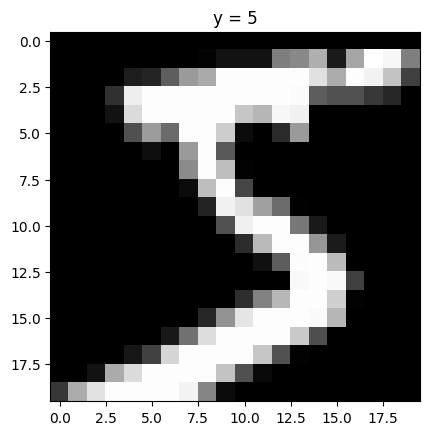

In [25]:
import matplotlib.pyplot as plt

# 첫 번째 샘플의 이미지 데이터 가져오기
image = training_data[0][0].view(20, 20)    # (1, 20, 20) → (20, 20)으로 변환

# 이미지 시각화
plt.imshow(image, cmap="gray")     # 흑백 이미지 표시
plt.title("y = {}".format(training_data[0][1]))  # 제목: 실제 레이블 값
plt.show()

## DataLoader를 사용하여 training 데이터 준비

Dataset은 `한 번에 한 개씩 샘플`의 feature 와 label 을 retreive 합니다. 모델을 훈련하는 동안 일반적으로 `minibatch`로 샘플을 전달하고, 매 epoch 마다 데이터를 reshuffle 하여 overfitting을 줄이며, Python의 multiprocessing을 사용하여 읽는 속도를 높입니다.

DataLoader는 쉬운 API로 이러한 복잡성 내용을 추상화한 반복자(iterable) 입니다.

In [26]:
from torch.utils.data import DataLoader  # DataLoader 임포트

# 학습 데이터 로더 생성
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

# 테스트 데이터 로더 생성
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

## DataLoader를 통해 반복
해당 데이터 세트를 ``Dataloader``에 로드 했으며 반복할 수 있습니다. 아래의 각 반복은`` train_features`` 및 ``train_labels`` ( batch_size=64 의 feature 및 label) 의 배치를 반환합니다.  ``shuffle=True``를 지정했기 때문에 모든 배치를 반복한 후에 데이터가 섞입니다.

In [27]:
# train_dataloader에서 첫 번째 배치를 가져오기
train_features, train_labels = next(iter(train_dataloader))

# 배치 데이터의 크기 출력
print(f"Feature batch shape: {train_features.size()}")  # 입력 이미지 텐서 크기
print(f"Labels batch shape: {train_labels.size()}")  # 레이블 텐서 크기

Feature batch shape: torch.Size([64, 1, 20, 20])
Labels batch shape: torch.Size([64])


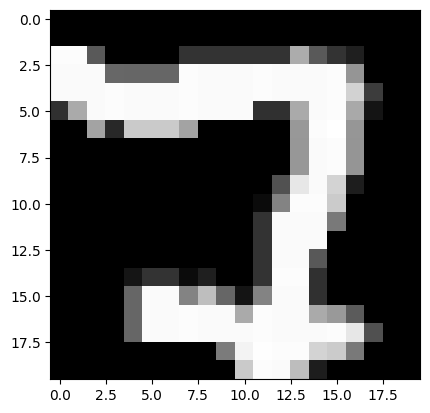

Label: 7


In [28]:
# 첫 번째 이미지 가져오기 (채널 차원 제거)
img = train_features[0].squeeze()

# 첫 번째 이미지의 라벨 가져오기
label = train_labels[0]

# 이미지 시각화
plt.imshow(img, cmap="gray")  # 흑백 이미지로 출력
plt.show()

# 해당 이미지의 레이블 출력
print(f"Label: {label}")

## TensorDataset
- PyTorch의 TensorDataset은 tensor를 감싸는 Dataset입니다.
- TensorDataset은 Dataset을 상속한 클래스로 학습 데이터 X와 레이블 Y를 묶어 놓는 컨테이너입니다.
- TensorDataset을 DataLoader에 전달하면 for 루프에서 데이터의 일부분만 간단히 추출할 수 있게 됩니다.  
- TensorDataset에는 텐서만 전달할 수 있으며, Variable은 전달할 수 없으니 주의
- Dataset은 직접 작성할 수도 있어서 대량의 이미지 파일을 한 번에 메모리에 저장하지 않고 필요할 때마다 읽어서 학습하는 등 다양하게 활용 가능

In [29]:
# 5x4 크기의 난수 행렬 생성 (정규 분포)
x = np.random.randn(5, 4)

# 0 또는 1 값을 가지는 정수 배열 생성 (크기 5)
y = np.random.randint(0, 2, size=5)

# NumPy 배열을 PyTorch 텐서로 변환
X_train = torch.from_numpy(x)  # 입력 데이터 변환
y_train = torch.from_numpy(y)  # 레이블 변환

# 변환된 텐서 출력
print(X_train)
print(y_train)

tensor([[-0.6537, -0.1277, -1.1101,  2.2363],
        [-0.0493,  0.8572, -0.4567, -0.4977],
        [-0.6265, -1.5822, -0.6064,  1.5870],
        [-0.2560,  0.4009, -0.9057,  1.0966],
        [ 0.4240, -1.5998, -0.6795, -0.2796]], dtype=torch.float64)
tensor([0, 0, 0, 1, 0])


In [31]:
from torch.utils.data import TensorDataset

# X_train(입력 데이터)와 y_train(레이블)을 하나의 데이터셋으로 묶기
train_ds = TensorDataset(X_train, y_train)

# 생성된 TensorDataset 출력
train_ds

In [32]:
# DataLoader 생성
train_dataloader = DataLoader(train_ds, batch_size=2, shuffle=False)

# 생성된 DataLoader 출력
train_dataloader

In [33]:
# DataLoader에서 첫 번째 배치 가져오기
train_features, train_labels = next(iter(train_dataloader))

# 배치 데이터 출력
train_features, train_labels

(tensor([[-0.6537, -0.1277, -1.1101,  2.2363],
         [-0.0493,  0.8572, -0.4567, -0.4977]], dtype=torch.float64),
 tensor([0, 0]))